In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.arima.model import ARIMA

In [7]:
df = pd.read_csv(r"/content/train.csv")

In [8]:
sunday_df = df[(df['Publication_Day'] == 'Sunday') & (df['Listening_Time_minutes'].notna())]
sunday_df = sunday_df.sort_values(by='id').reset_index(drop=True)
listening_series = sunday_df['Listening_Time_minutes'].reset_index(drop=True)

In [9]:
!pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 9.3 MB/s eta 0:00:00


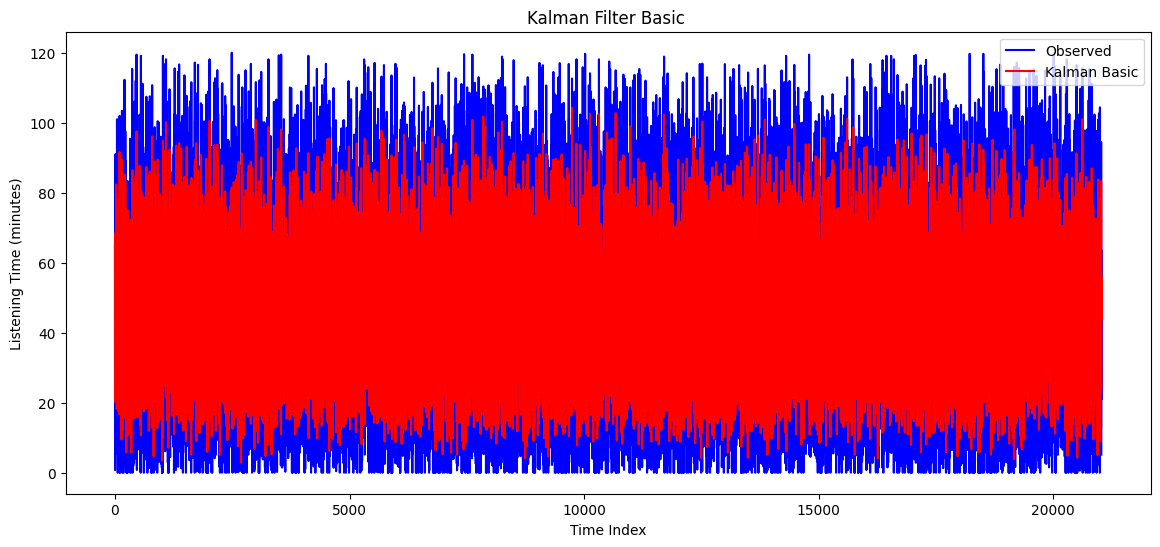

In [12]:

#Kalman Basic
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=listening_series[0],
    initial_state_covariance=1,
    observation_covariance=1.0,
    transition_covariance=1.0
)

state_means,_=kf.filter(listening_series)
plt.figure(figsize=(14, 6))
plt.plot(listening_series, label='Observed', color='blue')
plt.plot(state_means.flatten(), label='Kalman Basic', color='red')
plt.legend()
plt.title("Kalman Filter Basic ")
plt.xlabel("Time Index")
plt.ylabel("Listening Time (minutes)")
plt.show()

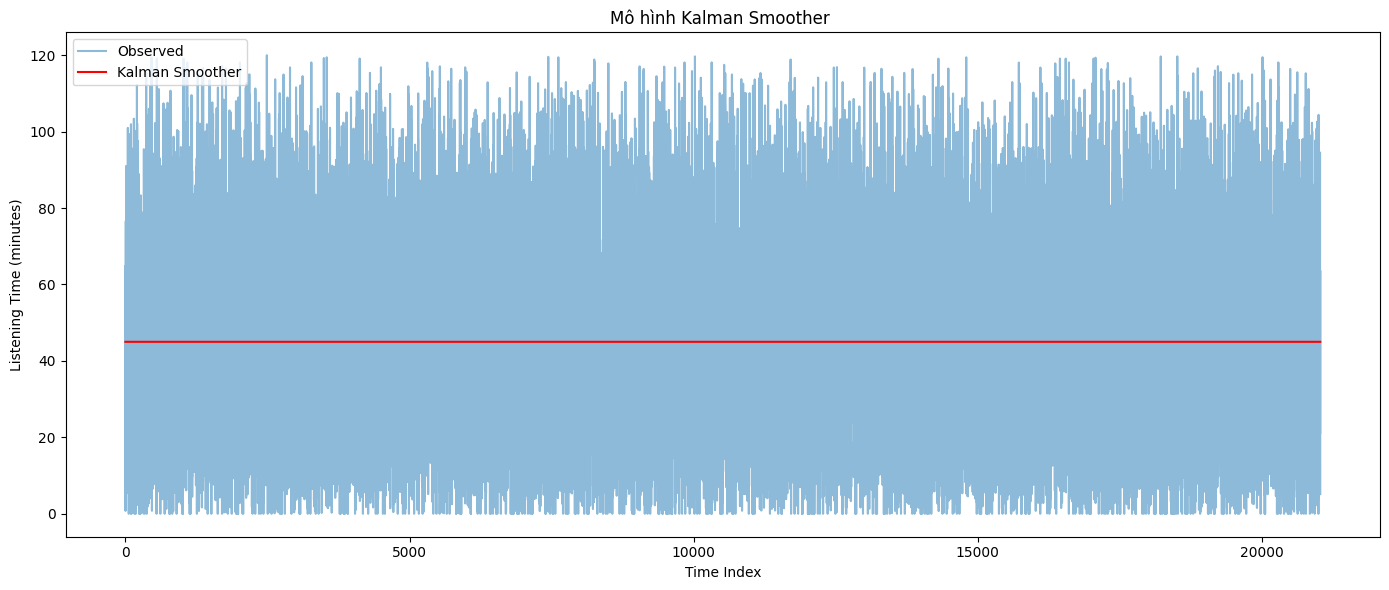

In [13]:
model1 = UnobservedComponents(listening_series, level='local level')
results1 = model1.fit(disp=False)
smoothed_values = results1.level.smoothed
plt.figure(figsize=(14, 6))
plt.plot(listening_series.values, label='Observed', alpha=0.5)
plt.plot(smoothed_values, label='Kalman Smoother', color='red')
plt.title("Mô hình Kalman Smoother ")
plt.xlabel("Time Index")
plt.ylabel("Listening Time (minutes)")
plt.legend()
plt.tight_layout()
plt.show()

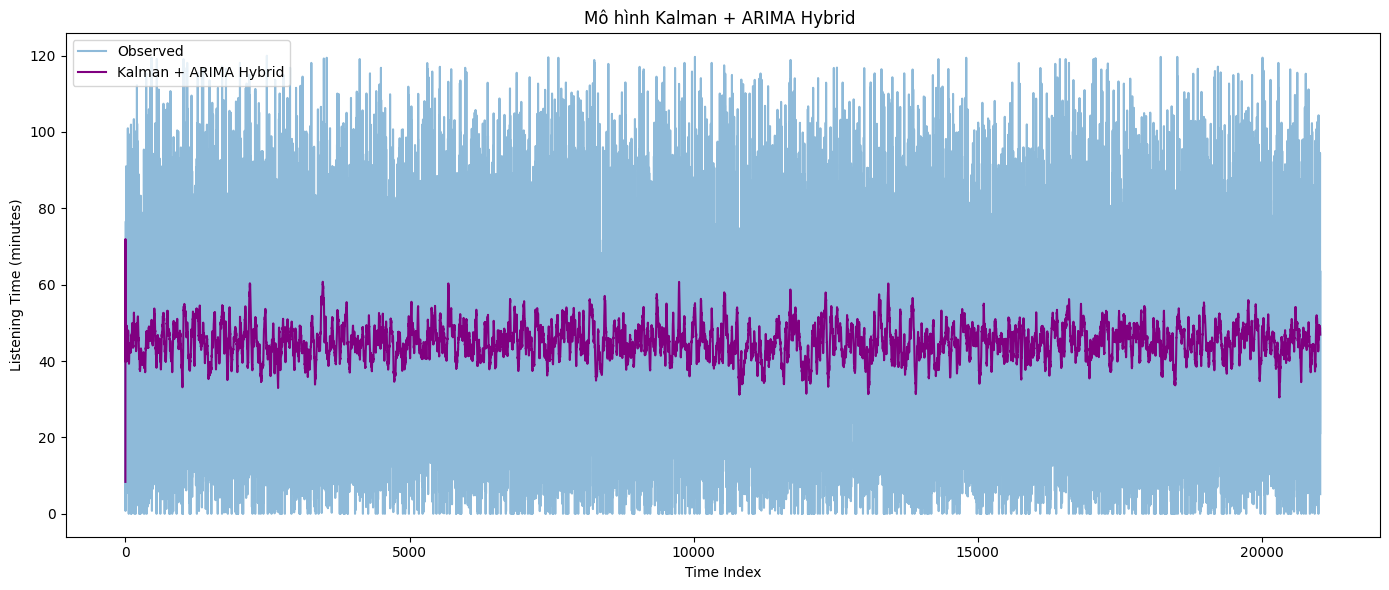

In [14]:
arima_model = ARIMA(listening_series, order=(1, 1, 1))
arima_result = arima_model.fit(method_kwargs={"maxiter": 100})

residuals = arima_result.resid.dropna()
kf_resid = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=residuals.iloc[0],
    initial_state_covariance=1,
    observation_covariance=1,
    transition_covariance=0.01
)
smoothed_resid, _ = kf_resid.smooth(residuals.values)

arima_pred = arima_result.fittedvalues
# Extract the first column (smoothed values) from the 2D array
hybrid_pred = arima_pred + smoothed_resid[:, 0]
plt.figure(figsize=(14, 6))
plt.plot(listening_series.values, label='Observed', alpha=0.5)
plt.plot(hybrid_pred, label='Kalman + ARIMA Hybrid', color='purple')
plt.title("Mô hình Kalman + ARIMA Hybrid ")
plt.xlabel("Time Index")
plt.ylabel("Listening Time (minutes)")
plt.legend()
plt.tight_layout()
plt.show()

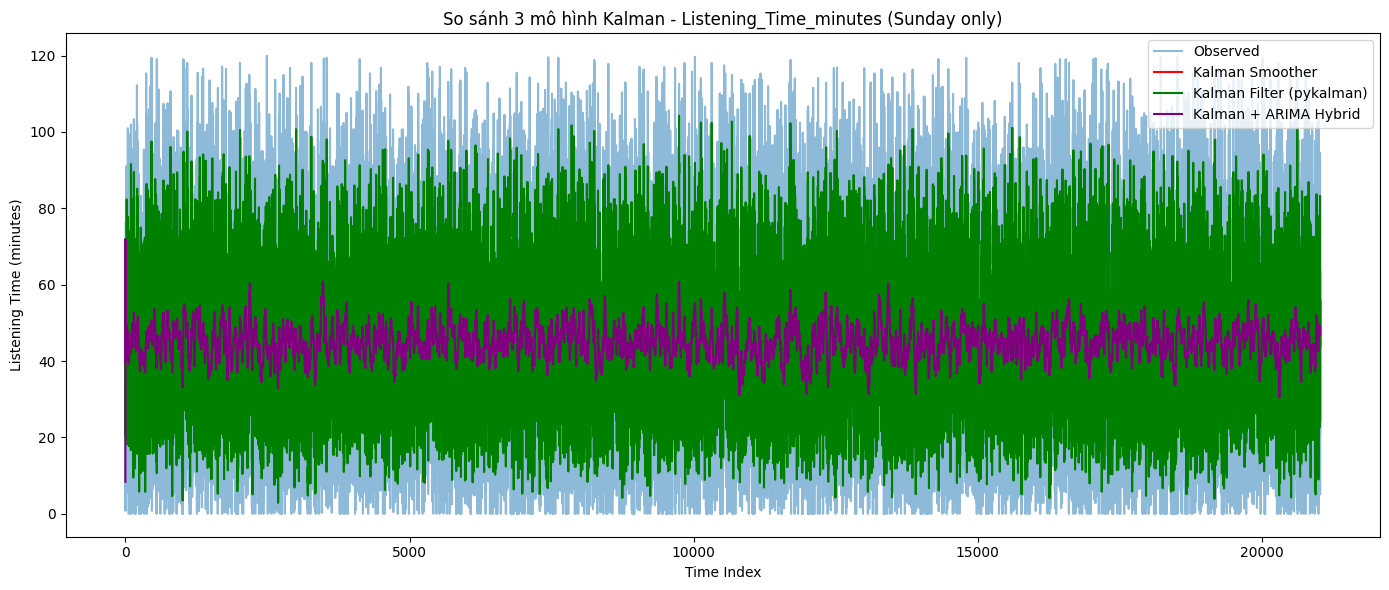

In [15]:
plt.figure(figsize=(14, 6))
plt.plot(listening_series.values, label='Observed', alpha=0.5)
plt.plot(smoothed_values, label='Kalman Smoother', color='red')
plt.plot(state_means, label='Kalman Filter (pykalman)', color='green')
plt.plot(hybrid_pred, label='Kalman + ARIMA Hybrid', color='purple')
plt.title("So sánh 3 mô hình Kalman - Listening_Time_minutes (Sunday only)")
plt.xlabel("Time Index")
plt.ylabel("Listening Time (minutes)")
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

true = listening_series.values

mae1 = mean_absolute_error(true, smoothed_values)
mae2 = mean_absolute_error(true, state_means)
mae3 = mean_absolute_error(true[-len(hybrid_pred):], hybrid_pred)

mse1 = mean_squared_error(true, smoothed_values)
mse2 = mean_squared_error(true, state_means)
mse3 = mean_squared_error(true[-len(hybrid_pred):], hybrid_pred)

rmse = lambda mse: np.sqrt(mse)

print("Kết quả đánh giá:")
print(f"1. Kalman Smoother   → MAE: {mae1:.2f}, MSE: {mse1:.2f}, RMSE: {rmse(mse1):.2f}")
print(f"2. Kalman Filter      → MAE: {mae2:.2f}, MSE: {mse2:.2f}, RMSE: {rmse(mse2):.2f}")
print(f"3. ARIMA + Kalman     → MAE: {mae3:.2f}, MSE: {mse3:.2f}, RMSE: {rmse(mse3):.2f}")


Kết quả đánh giá:
1. Kalman Smoother   → MAE: 22.39, MSE: 727.73, RMSE: 26.98
2. Kalman Filter      → MAE: 9.96, MSE: 152.25, RMSE: 12.34
3. ARIMA + Kalman     → MAE: 21.46, MSE: 672.67, RMSE: 25.94
